# Plotting and early analysis for Marina Borehole Data

In [194]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)
from funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Import data exported from WellProcessing.ipynb

In [196]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2(df)
MPWSPnames = df2.loc[df2.FRES.notnull(),'Well'].unique()
MWnames = df.index.levels[0].values

###  Archie's  Law
$$R_o = F*R_w $$
$$R_o = \phi^{-m}*R_w $$
### Arp's Law in degrees Fahrenheit
$$R_{w2} = R_{w1}\frac{T_1 + 6.77}{T_2 + 6.77}$$

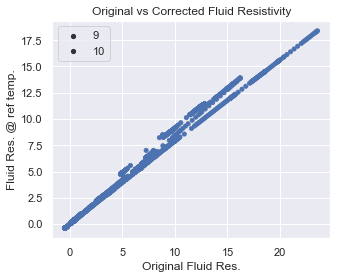

In [197]:
g = sns.scatterplot(data=df,x='FRES',y='FRESc',hue=None,edgecolor=None,size=10)
plt.gca().set_aspect(1)
plt.xlabel('Original Fluid Res.')
plt.ylabel('Fluid Res. @ ref temp.')
plt.title('Original vs Corrected Fluid Resistivity')
plt.show()

### Plot all boreholes: Bulk + fluid resistivity

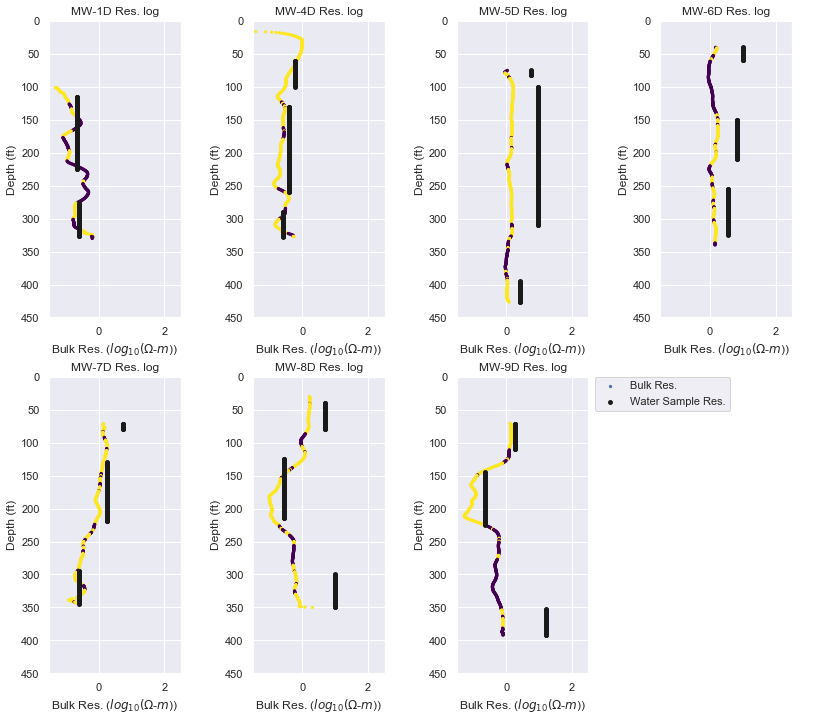

In [198]:
non_clays = ['SP','GP','SW','SM','SP-SM','ML','MH','SW-GW','SW-GP']
# df_plot = df.loc[mask_nonan(df,nan_cols),:]
# df_plot =  df[np.logical_and(np.logical_and(df.screen.notnull(),df.RILD.notnull()),df.lith=='SP')] 
# df_plot =  df[np.logical_and(df.RILD.notnull(),df.lith.isin(non_clays))] 
df_plot = df
s=5
f,axs=plt.subplots(2,4,figsize=(14,12))
plt.set_cmap('jet')
cmap = cm.get_cmap('viridis',len(df.lithnum_bin.unique()))  

for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i == axs.size-1:
        plt.axis('off')
        continue
    nam = MPWSPnames[i]
    ax.set_xlim([-1.5,2.5])
    ax.set_ylim([0,450])
    ax.invert_yaxis()
    d=df_plot.loc[nam].index
#     s2=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'RILD']),d,
#                 s=s, label='Bulk Res.',c='k')#c=df_plot.loc[nam].loc[:,'lithnum_bin'],cmap=cmap)
    s1=plt.scatter(df_plot.loc[nam].loc[:,'logrild_conv'],d,
                s=s, label='Bulk Res.',c=df_plot.loc[nam].loc[:,'lithnum_bin'],cmap=cmap)

#     tds1 = plt.scatter(np.log10(df_plot.loc[nam].loc[:,'ec_fresc']),df.loc[nam].index,
#                        c='k',s=3*s,label='Water Sample Res.',vmin=0, vmax=15000)
    
    tds1 = plt.scatter(np.log10(cond2rho(df_plot.loc[nam].loc[:,'EC1'])),df.loc[nam].index,
                       c='k',s=3*s,label='Water Sample Res.',vmin=0, vmax=15000)
#     s2=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'FRESc']),d,c='r',
#                 s=s,label='Fluid Res.')
    plt.ylabel('Depth (ft)')
    plt.xlabel('Bulk Res. ($log_{10}(\Omega$-$m$))');
    ax.set_aspect(1/50)
    plt.title(nam + ' Res. log');
    if i== axs.size-2:
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.colorbar(tds1)
# plt.savefig(figdir.joinpath('All_logs_lithology_bin.png'),dpi=500)

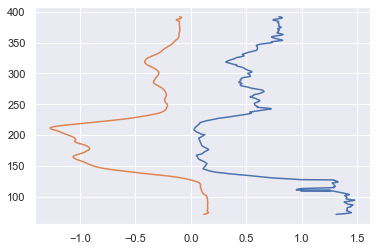

In [55]:
df2 = update_df2(df)
plt.plot(np.log10(df2.loc[df2.Well=='MW-9D','RILD']),df2.loc[df2.Well=='MW-9D','DEPT'])
plt.gca().invert_yaxis()

plt.plot(df2.loc[df2.Well=='MW-9D','logrild_conv'],df2.loc[df2.Well=='MW-9D','DEPT'])
plt.gca().invert_yaxis()

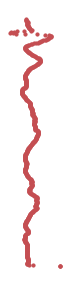

In [56]:
df_plot = df
s=10
f,ax=plt.subplots(1,1,figsize=(1,5))
ax.axis('off')
cmap = cm.get_cmap('viridis',2)
i=3
nam = MWnames[i]
color = np.ones(len(df_plot.loc[nam]))
color[df_plot.loc[nam].loc[:,'screen'].isna()]=0
ax.invert_yaxis()
d=df_plot.loc[nam].index
s1=plt.scatter(np.log10(df_plot.loc[nam].loc[:,'RILD']),d,
            s=s, label='Bulk Res.',c='r')

# plt.savefig(figdir.joinpath('RILD_red.pdf'),dpi=500,bbox_inches='tight')

In [57]:
from scipy import stats
def x_y_regression(xin,yin,cin,msk=None,plotslp=True,slpname='F',kdeplot=False,plotone2one=False,returnslope=False,**kwargs):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    f,ax = plt.subplots(1,figsize=(5,4))
    if kdeplot:
        sns.kdeplot(x,y)
    plt.scatter(x,y,c=c,**kwargs)
    plt.plot(x,slope*x + intercept,':k',label='L2 best fit')
    if plotone2one:
        one2one = np.linspace(x.min(),x.max())
        plt.plot(one2one,one2one,'k',label='y=x')
    if plotslp:
#         plt.text(x.max()-(x.max()-x.min())*.75,y.max()-(y.max()-y.min())*.10,'{} = {:.2f} \n$R^2$ = {:.2f}'.format(slpname,slope,r_value**2))
        plt.text(0.05,.80,'{} = {:.2f} \n$R^2$ = {:.2f} \nRMSE = {:.2f}'
                 .format(slpname,slope,r_value**2,np.sqrt(np.mean((y-x*slope)**2))),transform=ax.transAxes)
    else:
        plt.text(0.05,.80,'$R^2$ = {:.2f} \nRMSE = {:.2f}'
                 .format(slope,r_value**2,np.sqrt(np.mean((y-x*slope)**2))),transform=ax.transAxes)
    if returnslope:
        return f,ax,slope
    else:
        return f,ax

### Applying Archie's Law: All measurements

<Figure size 432x288 with 0 Axes>

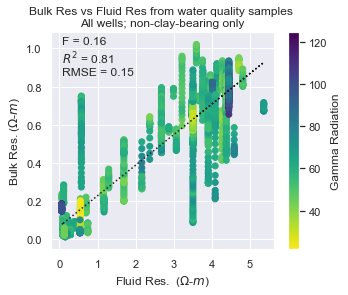

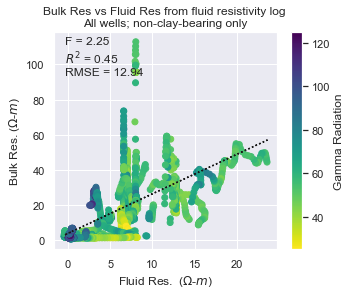

In [58]:
# df_plot = df.loc[mask_nonan(df,nan_cols),:]
# df_plot = df_plot.loc[mask_SP_only(df_plot,nan_cols),:]
# mask = mask_stds(df_plot,1.2,'RILD',nan_cols)
conditions = (df.screen.notnull(),df.RILD.notnull())
df_plot =  df.loc[nested_logicals(df,conditions,np.logical_and)]
# df_plot =  df[np.logical_and(df.screen.notnull(),df.RILD.notnull())] 



# x = cond2rho(df_plot.loc[:,'EC1f'])
x=df_plot.loc[:,'EC1f']/1e4
y = 1/df_plot.loc[:,'RILD']
c = pd.DataFrame(df_plot.index.to_list(),columns=['Well','DEPT'])['DEPT']
c = df_plot.loc[:,'GR']
f,ax1 = x_y_regression(x,y,c);
ax1.set_title('Bulk Res vs Fluid Res from water quality samples \nAll wells; non-clay-bearing only')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
cb = plt.colorbar()
cb.set_label('Gamma Radiation', rotation=90)
plt.savefig(figdir.joinpath('FRESvEC1f_non_clay.png'),dpi=300)


df_plot = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.FRES.notnull()),df.lith.isin(non_clays))]

# df_plot =  df[np.logical_and(df.RILD.notnull(),df.FRES.notnull())] 

x = df_plot.loc[:,'FRES']
y = df_plot.loc[:,'RILD']
# c = pd.DataFrame(df_plot.index.to_list(),columns=['Well','DEPT'])['DEPT']
c = df_plot.loc[:,'GR']
f,ax2 = x_y_regression(x,y,c,vmin=25,vmax=125);

ax2.set_title('Bulk Res vs Fluid Res from fluid resistivity log \nAll wells; non-clay-bearing only')
plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
plt.ylabel('Bulk Res. ($\Omega$-$m$)')
cb = plt.colorbar()
cb.set_label('Gamma Radiation', rotation=90)
# plt.savefig(figdir.joinpath('FRESvRILD_non_clay.png'),dpi=300)

### Archie's Law: borehole-by-borehole 

<Figure size 432x288 with 0 Axes>

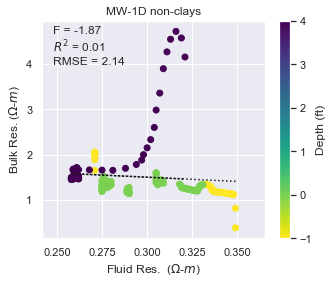

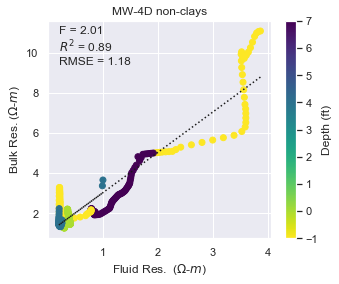

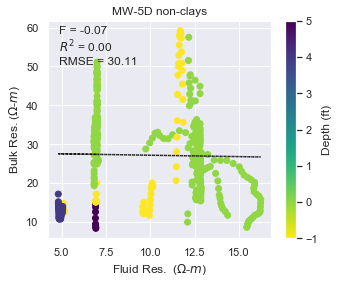

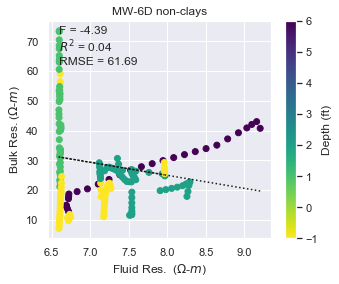

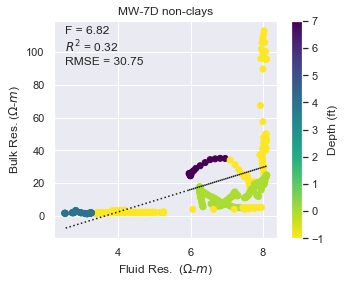

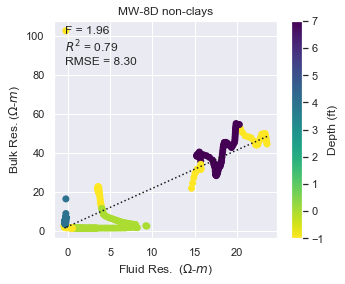

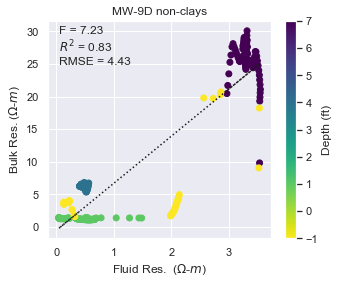

In [59]:

# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df_plot = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.FRES.notnull()),df.lith.isin(non_clays))] 

# mask = mask_nonan(df_plot,nan_cols)

for i,nam in enumerate(MPWSPnames):
    x = df_plot.loc[nam].loc[:,'FRES']
    y = df_plot.loc[nam].loc[:,'RILD']
    c = df_plot.loc[nam].index
    c = df_plot.loc[nam].loc[:,'aqnum']
    f,ax = x_y_regression(x,y,c);
    ax.set_title(nam + ' non-clays')
    plt.xlabel('Fluid Res.  ($\Omega$-$m$)')
    plt.ylabel('Bulk Res. ($\Omega$-$m$)')
    cb = plt.colorbar()
    cb.set_label('Depth (ft)', rotation=90)
#     plt.savefig(figdir.joinpath('FRESvRILD_non_clay{}.png'.format(nam)),dpi=300)

### Aquifer number

In [60]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

### Archie's Law: aquifer-by-aquifer

<Figure size 432x288 with 0 Axes>

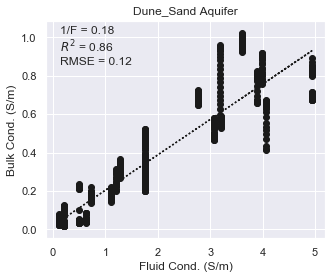

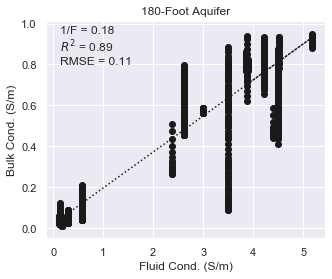

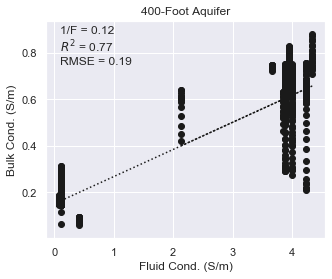

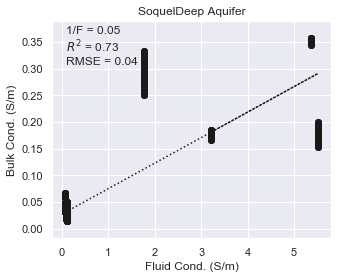

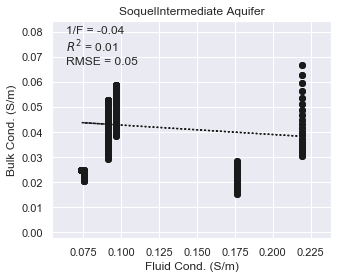

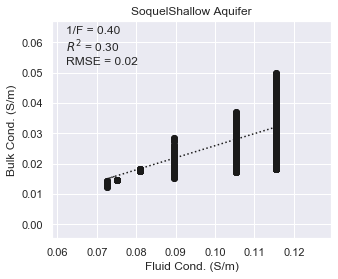

In [199]:
# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df = df.assign(cond_est= (1/tds2rho_est(df.TDS1).astype(np.float)))
df2=update_df2(df)

conditions = (df2.RILD.notnull(),
              df2.cond_est.notnull())#,
#              df2.Region=='Marina')
df_plot = df2.loc[nested_logicals(df2,conditions)]

# df_plot = df2[np.logical_and(df2.RILD.notnull(),df2.EC1f.notnull())] 
df_plot = df_plot.assign(logrhoEC1f = np.log10(cond2rho(df_plot.loc[:,'EC1f'])))
df_plot = df_plot.assign(logrild = np.log10(df_plot.loc[:,'RILD']))

# df[df.Aquifer==aq_names[0]]
slopes={}
for i,nam in enumerate(aq_groupnames):
    x = df_plot[df_plot.AquiferGroup==nam].loc[:,'cond_est']
    y = 1/df_plot[df_plot.AquiferGroup==nam].loc[:,'RILD']
    c = df_plot[df_plot.AquiferGroup==nam].loc[:,'aqnum']
    c='k'
    if len(x)>0:
        f,ax,slope = x_y_regression(x,y,c,plotslp=True,slpname='1/F',returnslope=True);
        ax.set_title(nam + ' Aquifer')
        plt.xlabel('Fluid Cond. (S/m)')
        plt.ylabel('Bulk Cond. (S/m)')
    #     cb = plt.colorbar()
    #     cb.set_label('Depth (ft)', rotation=90)
#         plt.savefig(figdir.joinpath('Archie_'+nam+'.png'.format(nam)),dpi=300,bbox_inches='tight')
        slopes[nam] = slope

In [200]:
F = np.zeros(len(df))

for nam,slope in slopes.items():
    F[(df.AquiferGroup==nam).values]=slope
#     F[(df.AquiferGroup=='180-Foot').values]=F_180
#     F[(df.AquiferGroup=='400-Foot').values]=F_400
F[F==0] = np.nan
df = df.assign(F=F)
df2 = update_df2(df)

In [201]:
wellids = df2.Well.unique()
welldict = {}
for i,nam in enumerate(wellids):
    welldict[nam]=i

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


<Figure size 432x288 with 0 Axes>

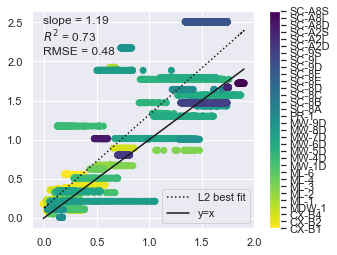

In [202]:
df = df.assign(F=F)
df2=update_df2(df)

y_test = np.log10(df2.RILD.values)
y_pred = np.log10((1/(df2.EC1f/1e4 * df2.F )).values )
df = df.assign(logrild_pred_archie=y_pred)

c = np.asarray([welldict[nam] for nam in df2.Well])
ticks=  [num for nam,num in welldict.items() if (num in c)]
ticklabels = [nam for nam,num in welldict.items() if (num in c)]

msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
x_y_regression(y_test,
               y_pred,
               c,
              plotone2one=True,
              slpname='slope')
plt.legend(loc='lower right')
cb = plt.colorbar()
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)


### Waxman Smits
#### Co = (Cw + BxQv) x (1/F)

#### Cw = Co / (1/F) - B x Qv


B: .5-4

Qv: montmorellinite 0.8 to 1.5

In [203]:
max_Qv_val=1.5
def qv(lith,max_val=max_Qv_val):
    Qv = np.zeros(np.shape(lith))
    ind = [i for i,v in enumerate(lith) if str(v).startswith('C')]
    Qv[ind]=1*max_val
    ind = [i for i,v in enumerate(lith) if (('C' in str(v)) & (Qv[i]==0))]
    Qv[ind]=.5*max_val
    return Qv

<Figure size 432x288 with 0 Axes>

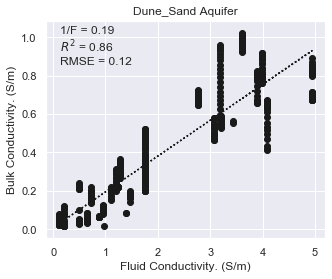

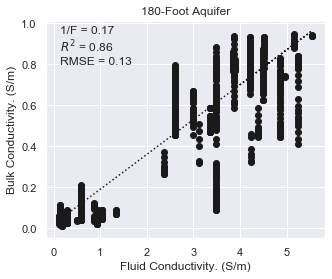

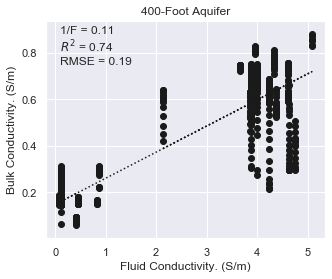

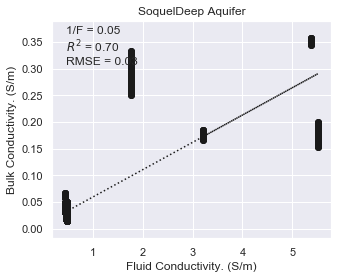

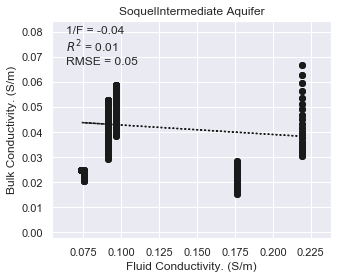

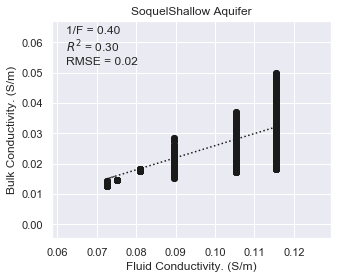

In [204]:
B=.5

# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df = df.assign(cond_est= (1/tds2rho_est(df.TDS1).astype(np.float)))
df2=update_df2(df)

conditions = (df2.RILD.notnull(),
              df2.cond_est.notnull())#,
#              df2.Region=='Marina')
df_plot = df2.loc[nested_logicals(df2,conditions)]

df_plot = df_plot.assign(Qv = qv(df_plot.lith.values))
df_plot = df_plot.assign(logrhoEC1f = np.log10(cond2rho(df_plot.loc[:,'EC1f'])))
df_plot = df_plot.assign(logrild = np.log10(df_plot.loc[:,'RILD']))


# df_plot = df_plot.loc[~(df_plot.Well=='CX-B1')]
# df[df.Aquifer==aq_names[0]]
slopes={}
for i,nam in enumerate(aq_groupnames):
    x = df_plot[df_plot.AquiferGroup==nam].loc[:,'cond_est'] + B*df_plot[df_plot.AquiferGroup==nam].loc[:,'Qv']
    y = 1/df_plot[df_plot.AquiferGroup==nam].loc[:,'RILD']
    c = df_plot[df_plot.AquiferGroup==nam].loc[:,'aqnum']
    c='k'
    if len(x)>0:
        f,ax,slope = x_y_regression(x,y,c,plotslp=True,slpname='1/F',returnslope=True);
        ax.set_title(nam + ' Aquifer')
        plt.xlabel('Fluid Conductivity. (S/m)')
        plt.ylabel('Bulk Conductivity. (S/m)')
        slopes[nam] = slope
# print(np.round(slopes,2))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


n data after 6509


<Figure size 432x288 with 0 Axes>

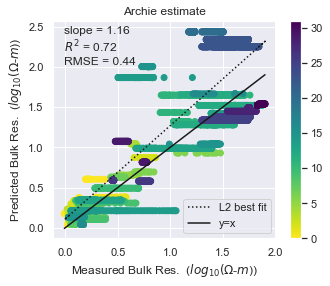

<Figure size 432x288 with 0 Axes>

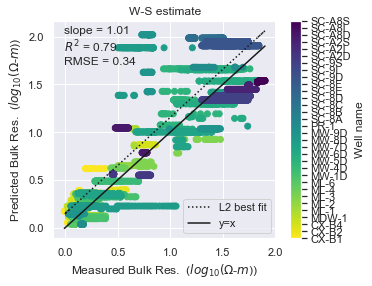

In [278]:
F = np.zeros(len(df))

for nam,slope in slopes.items():
    F[(df.AquiferGroup==nam).values]=slope
#     F[(df.AquiferGroup=='180-Foot').values]=F_180
#     F[(df.AquiferGroup=='400-Foot').values]=F_400
F[F==0] = np.nan
df = df.assign(F_WS=F)
df2 = update_df2(df)
#(Cw + BxQv) x (1/F)


y_test = np.log10(df2.RILD.values)
y_pred_archie = np.log10(1/((df2.cond_est)*df2.F)).values
# y_pred_ws = np.log10(1/((df2.cond_est + B*qv(df2.lith.values,max_val=.5))*df2.F_WS)).values
# print('n data before',len(y_pred_ws[~np.isnan(y_pred_ws)]))
y_pred_ws = np.log10((1/((df2.cond_est + B*qv(df2.lith.values,max_val=.5))*df2.F_WS)).astype(np.float)).values
Cw_pred_ws = (((1/df2.RILD) / df2.F_WS) - B*qv(df2.lith.values,max_val=.5)).values
#Cw = Co / (1/F) - B x Qv


print('n data after',len(y_pred_ws[~np.isnan(y_pred_ws)]))

df = df.assign(logrild_pred_ws=y_pred_ws)
df = df.assign(Cw_pred_ws=Cw_pred_ws)

df = df.assign(logrild_pred_archie=y_pred_archie)
c = np.asarray([welldict[nam] for nam in df2.Well])


msk=~np.isnan(y_pred_archie)
y_test = y_test[msk]
y_pred_archie = y_pred_archie[msk]
y_pred_ws = y_pred_ws[msk]
c = c[msk]
x_y_regression(y_test,
               y_pred_archie,
                c,
              plotone2one=True,
              slpname='slope')
plt.legend(loc='lower right')
plt.colorbar()
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.title('Archie estimate')
plt.show()

x_y_regression(y_test,
               y_pred_ws,
                c,
              plotone2one=True,
              slpname='slope')
plt.legend(loc='lower right')
cb = plt.colorbar()
# allwells = [nam for nam,num in welldict.items()]
ticks=  [num for nam,num in welldict.items()]
ticklabels = [nam for nam,num in welldict.items()]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')
cb.ax.set_ylabel('Well name')
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.title('W-S estimate')
plt.savefig(figdir.joinpath('WS_all.png'.format(nam)),dpi=300,bbox_inches='tight')

In [281]:
df2 = update_df2(df)

0.1855193281965741

In [282]:
df.to_pickle(lasdir.joinpath('allMWs_SC'))


### Create data from W-S model to boost training set

In [265]:
def create_ws_data(df_testing,n_samples, pcterr=5,B=.5,max_val=.5):
    df_samps = resample(df_testing,n_samples=n_samples)
#     df_samps= df_samps.assign(TDS1= resample(df_testing.TDS1,n_samples=n_samples).values)
#     df_samps= df_samps.assign(cond_est= (1/tds2rho_est(df_samps.TDS1).astype(np.float)))
    df_samps= df_samps.assign(lith= resample(df_testing.lith,n_samples=n_samples).values)
    y_pred_ws = np.log10((1/((df_samps.cond_est + 
                              B*qv(df_samps.lith.values,max_val=max_val))*df_samps.F_WS)))
    
    err = np.mean(y_pred_ws)*pcterr/100*np.random.normal(size=y_pred_ws.shape)
#     df_samps= df_samps.assign(logrild_pred_ws=y_pred_ws)
    df_samps= df_samps.assign(logrild_pred_ws=y_pred_ws)
    df_samps= df_samps.assign(RILD=np.power(10,y_pred_ws + err))
    return df_samps

In [268]:
n_samples=10000
# B=np.random.uniform(.1,.8,size=(n_samples,))
# max_val = np.random.uniform(.1,.8,size=(n_samples,))
B=.5
list_of_conditions = (df2.RILD.notnull(),
                      df2.TDS1.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

df_testing = df2.loc[nested_logicals(df2,list_of_conditions,func=np.logical_and)]
df2_samp = create_ws_data(df_testing,n_samples=10000, pcterr=5,B=B)
df2_samp = df2_samp.assign(samp=True)
df_testing = df_testing.assign(samp=False)
df2_samp = pd.concat((df2_samp,df_testing))
df2_samp.to_pickle(lasdir.joinpath('allMWs_samp'))

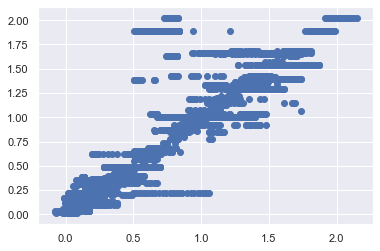

In [263]:
plt.scatter(np.log10(df2_samp.RILD),df2_samp.logrild_pred_ws)

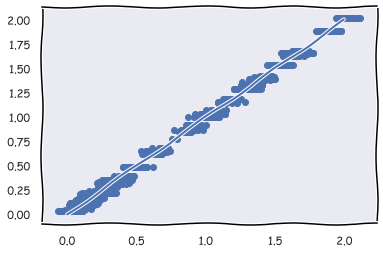

In [124]:
from numpy.linalg import norm
with plt.xkcd(randomness=2):

    plt.scatter(y_pred_ws_err,y_pred_ws)
    plt.plot([0,2],[0,2])


### Regression Tree v Classification Tree

In [29]:
df=update_FBS(df,'TDS1',breaks=np.arange(0,11000,1000))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


<Figure size 432x288 with 0 Axes>

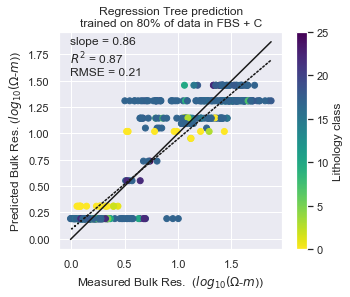

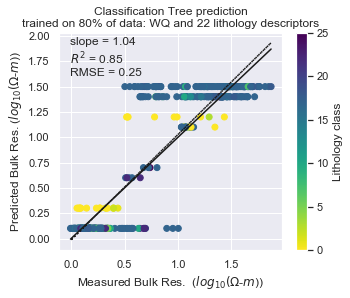

In [36]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from subprocess import call
np.random.seed(1)
######## Prediction variables  ################
# ## Predict from FRES and lith
# predicted = 'logrild'
# predictors = ['logfres','lithnum']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]


# #Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
predictors = ['FBS','C']
df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##############################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.get_dummies(df_testing,drop_first=False)
# ###################################


#Separate training from test data
y_all = df_testing.loc[:,predicted].values
df_train, df_test, y_train, y_test = train_test_split(df_testing, y_all, test_size=0.2)

y_train = y_train[:,0].astype(np.int)
y_test = y_test[:,1]

X_train = df_train.loc[:,predictors]
X_test = df_test.loc[:,predictors]

# Fit regression model
max_depth = 10

regr_1 = DecisionTreeRegressor(max_depth=max_depth)
regr_1.fit(X_train, y_train)

regr_2 = DecisionTreeClassifier(max_depth=max_depth)
regr_2.fit(X_train, y_train)


# Predict
y_1 = regr_1.predict(X_test)/10
y_2 = regr_2.predict(X_test)/10

#Plotting 
# mins = min(ax.get_ylim()[0],ax.get_xlim()[0])
# maxs = max(ax.get_ylim()[1],ax.get_xlim()[1])
# ax.plot(np.linspace(mins,maxs,10),np.linspace(mins,maxs,10))
# ax.set_aspect(1)
# cmap = cm.get_cmap('viridis',10 )  


f,ax = x_y_regression(y_test.squeeze(),
                      y_1,
                      df_test.lithnum,
                      plotslp=True,slpname='slope',plotone2one=True)#,cmap=cmap,vmin=25,vmax=100);
ax.set_title('Regression Tree prediction\ntrained on 80% of data in {}'.format(' + '.join(predictors[:2])))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
cb = plt.colorbar()
cb.set_label('Lithology class', rotation=90)
fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
# plt.savefig(figdir.joinpath('RegTreePred_'+fig_suffix),bbox_inches='tight',dpi=300)


f,ax = x_y_regression(y_test.squeeze(),
                      y_2,
                      df_test.lithnum,
                      plotslp=True,slpname='slope',plotone2one=True,kdeplot=False)#,cmap=cmap,vmin=25,vmax=100);
# ax.set_title('Classification Tree prediction\ntrained on 80% of data in {}'.format(' + '.join(predictors[:2])))
ax.set_title('Classification Tree prediction\ntrained on 80% of data: WQ and 22 lithology descriptors')

plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res.  ($log_{10}(\Omega$-$m$))')
cb = plt.colorbar()
cb.set_label('Lithology class', rotation=90)
fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))

# # #Export graphs
# plt.savefig(figdir.joinpath('ClasffsTreePred_'+fig_suffix),bbox_inches='tight',dpi=300)
export_tree(figdir,regr_2,max_depth=5,predictors=predictors,prefix='RegTree_',feature_names=predictors)